STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

torch: 1.8.0



# AlexNet on Cifar-10

## Imports

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples
from helper_dataset import get_dataloaders_cifar10, UnNormalize

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [5]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [6]:
##########################
### MNIST DATASET
##########################

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = torchvision.transforms.Compose([            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


## Model

In [7]:
class ConvNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.layers = torch.nn.Sequential(
                torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
                torch.nn.BatchNorm2d(32),
                torch.nn.LeakyReLU(0.1, inplace=True),
                #
                torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                torch.nn.BatchNorm2d(64),
                torch.nn.LeakyReLU(0.1, inplace=True),
                #
                torch.nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
                torch.nn.BatchNorm2d(64),
                torch.nn.LeakyReLU(0.1, inplace=True),
                #
                torch.nn.Flatten(),
                torch.nn.Linear(4096, 128),
                torch.nn.BatchNorm1d(128),
                torch.nn.LeakyReLU(0.1, inplace=True),
                torch.nn.Dropout(0.5),
                #
                torch.nn.Linear(128, num_classes),
                )

    def forward(self, x):
        logits = self.layers(x)
        #probas = torch.softmax(logits, dim=1)
        return logits

Epoch: 001/050 | Batch 0000/0175 | Loss: 2.4832
Epoch: 001/050 | Batch 0100/0175 | Loss: 1.4447
Epoch: 001/050 | Train: 52.59% | Validation: 52.26%
Time elapsed: 0.63 min
Epoch: 002/050 | Batch 0000/0175 | Loss: 1.2109
Epoch: 002/050 | Batch 0100/0175 | Loss: 1.0998
Epoch: 002/050 | Train: 66.14% | Validation: 63.28%
Time elapsed: 1.28 min
Epoch: 003/050 | Batch 0000/0175 | Loss: 1.0204
Epoch: 003/050 | Batch 0100/0175 | Loss: 0.9906
Epoch: 003/050 | Train: 70.68% | Validation: 67.04%
Time elapsed: 1.98 min
Epoch: 004/050 | Batch 0000/0175 | Loss: 0.8259
Epoch: 004/050 | Batch 0100/0175 | Loss: 0.9525
Epoch: 004/050 | Train: 73.65% | Validation: 70.14%
Time elapsed: 2.66 min
Epoch: 005/050 | Batch 0000/0175 | Loss: 0.7508
Epoch: 005/050 | Batch 0100/0175 | Loss: 0.8660
Epoch: 005/050 | Train: 78.28% | Validation: 72.88%
Time elapsed: 3.34 min
Epoch: 006/050 | Batch 0000/0175 | Loss: 0.7427
Epoch: 006/050 | Batch 0100/0175 | Loss: 0.6461
Epoch: 006/050 | Train: 80.48% | Validation: 73.2

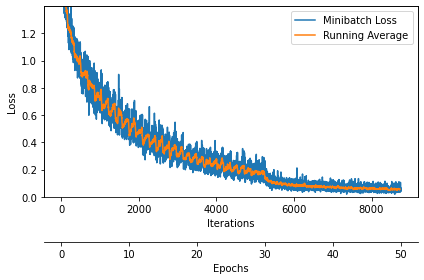

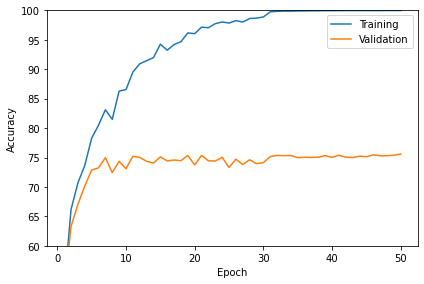

In [8]:
model = ConvNet(num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

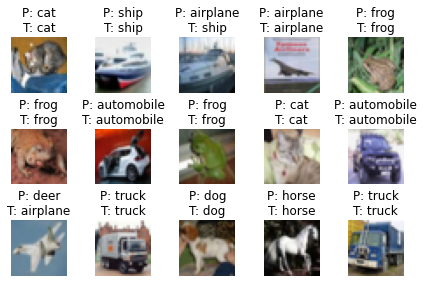

In [9]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)